<h1><center>Tomography with TomoPy & Astra Toolbox

In [1]:
import tomopy
import numpy as np
import astra
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

<h3> <center> Shepp–Logan Phantom </center></h3>
The Shepp–Logan phantom is a standard test image created by Larry Shepp and Benjamin F. Logan for their 1974 paper The Fourier Reconstruction of a Head Section. It serves as the model of a human head in the development and testing of image reconstruction algorithms

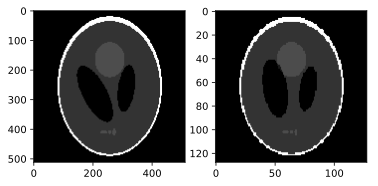

In [2]:
phantom2d = tomopy.misc.phantom.shepp2d().squeeze()
phantom3d = tomopy.misc.phantom.shepp3d()

plt.figure()
plt.subplot(121); plt.imshow(phantom2d, cmap='gray');
plt.subplot(122); plt.imshow(phantom3d[64,:,:], cmap='gray');

<h3><center> Radon Transform </center></h3>
<img src='Radon_transform.png' width=30% align='left'>
$$R(L) = \int_L f(\mathbf{x})\,|d\mathbf{x}|.$$
Concretely, the parametrization of any straight line $L$ with respect to arc length $z$ can always be written
$$(x(z),y(z)) = \Big( (s\cos\alpha - z\sin\alpha), (s\sin\alpha+z\cos\alpha)  \Big) \,$$
where $s$ is the distance of $L$ from the origin and $\alpha$ is the angle the normal vector to $L$ makes with the $x$ axis.  It follows that the quantities $(\alpha, s)$  can be considered as coordinates on the space of all lines in $R$<sup>2</sup>, and the Radon transform can be expressed in these coordinates by
$$\begin{align}R(\alpha,s) &= \int_{-\infty}^{\infty} f(x(z),y(z))\, dz\\ &= \int_{-\infty}^{\infty} f\big(  (s\cos\alpha - z\sin\alpha), (s\sin\alpha+z\cos\alpha) \big)\, dz\end{align}$$


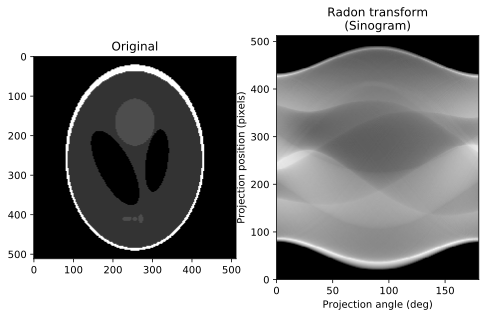

In [3]:
# 2D
theta2d = np.linspace(0., 180., max(phantom2d.shape), endpoint=False)
sinogram2d = radon(phantom2d, theta=theta2d, circle=True)

plt.figure(figsize=(8, 4.5));
plt.subplot(121)
plt.title("Original")
plt.imshow(phantom2d, cmap='gray')
plt.subplot(122)
plt.imshow(sinogram2d, cmap='gray',
           extent=(0, 180, 0, sinogram2d.shape[0]), aspect='auto');
plt.title('Radon transform\n(Sinogram)');
plt.xlabel("Projection angle (deg)");
plt.ylabel("Projection position (pixels)");

### <center>Back Projection </center>
The projections are defined as $p_\theta(s) \equiv R(\alpha,s)\big|_{\alpha=\theta}$. Backprojection represents the accumulation of the ray-sums of all the rays that pass through any point:
$$b(x,y) = \int_0^{\pi}p_\theta(s)d\theta.$$
The backprojection operation is **NOT** the inverse of the projection operation.
<img src='bp.png'>

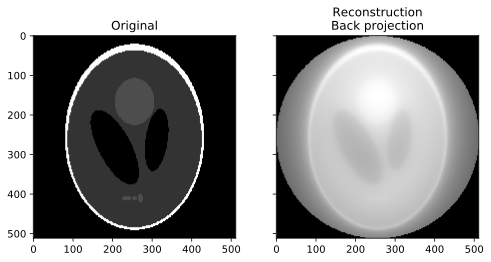

In [4]:
# Back Projection
reconstruction_bp = iradon(sinogram2d, theta=theta2d, circle=True, filter=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Original");
ax1.imshow(phantom2d, cmap='gray');
ax2.set_title("Reconstruction\nBack projection");
ax2.imshow(reconstruction_bp, cmap='gray');

### <center>Filtered Back Projection 
$$b(x,y) = \int_0^{\pi}\hat p_\theta(s)d\theta,$$
where is $\hat p(s)$ the filtered version of  $p(s)$:
$$\hat p(s)=\int_{-\infty}^{\infty}P_\theta(\omega) f(\omega) e^{2\pi i\omega s} d\omega.$$
Here $P_\theta(s)$ is 1D Fourier Transform of $p(\theta)$.

Different filter kernels:
<img src='filters.jpg' width=50%>

For more details see [link](http://article.sapub.org/10.5923.j.ijps.20150401.02.html).

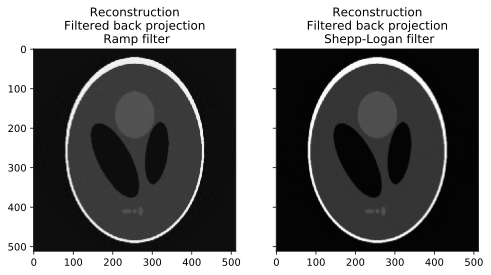

In [5]:
# Filtered Back Projection
reconstruction_fbp = iradon(sinogram2d, theta=theta2d, circle=True)
reconstruction_fbp_shl = iradon(sinogram2d, theta=theta2d, circle=True, filter='shepp-logan')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection\n Ramp filter");
ax1.imshow(reconstruction_fbp, cmap='gray');
ax2.set_title("Reconstruction\nFiltered back projection\n Shepp-Logan filter");
ax2.imshow(reconstruction_fbp_shl, cmap='gray');

<h3> <center> Relationship with the Fourier Transform</center></h3>
The Radon transform is closely related to the Fourier transform. We define the 2D Fourier transform here as
$$F(k_x,k_y)=\int\limits_{-\infty}^{\infty}\int\limits_{-\infty}^{\infty} f(x,y) e^{-i (k_x x + k_y y)} dx dy.$$
Denote $\vec{k}=(k_x,k_y)=\omega(\cos\alpha,\sin\alpha)$ and introduce new variables $s=x\cos\alpha+y\sin\alpha,   z=-x\sin\alpha+y\cos\alpha$. 
Thus,
$$F(\omega\cos\alpha,\omega\sin\alpha)=\int\limits_{-\infty}^{\infty} \left( \int\limits_{-\infty}^{\infty} f(s\cos\alpha-z\sin\alpha, s\sin\alpha+z\cos\alpha) e^{-i\omega s} dz \right) ds $$
and
$$F(\omega\cos\alpha,\omega\sin\alpha)= \int\limits_{-\infty}^{\infty} e^{-i\omega s} R(s,\alpha) ds.$$
Thus the <b>two-dimensional</b> Fourier transform of the initial function along a line at the inclination angle $\alpha$ is the <b>one-dimensional</b> Fourier transform of the Radon transform (acquired at angle $\alpha$) of that function. This fact can be used to compute both the Radon transform and its inverse.


<h3> <center> Radon Inversion Formula (FBP) </center></h3>
Since Fourier transform is 	invertible,
$$f(x,y)=\frac{1 }{(2\pi)^2} \int\limits_0^{2\pi} d \alpha\int\limits_{0}^{\infty} e^{i \omega(x\cos\alpha+y\sin\alpha)}\ \tilde{R}(\omega,\alpha) \omega d\omega,$$ 
where $\tilde{R}(\omega,\alpha)=\int\limits_{-\infty}^{\infty} R(s,\alpha)e^{-i\omega s} ds$.

#### <span style="color:blue">**This is Filtered Back Projection with kernel $|\omega|$ (Ramp filter)!**

<h3> <center> Projection-slice theorem </center></h3>
Apply the direct Fourier transform operation to the Radon transform of $f(x,y)$:

$$\int\limits_{-\infty}^{\infty} R(s,\alpha) e^{-i \omega s}  ds = 
 \int\limits_{-\infty}^{\infty} \left( \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} f(x,y) \delta(s - x \cos\alpha - y \sin\alpha) dx dy \right) e^{-i \omega s}  ds .$$

Then,

$$\int\limits_{-\infty}^{\infty} R(s,\alpha) e^{-i \omega s}  ds =   \int\limits_{-\infty}^{\infty}  \int\limits_{-\infty}^{\infty} \left( \int\limits_{-\infty}^{\infty} e^{-i \omega s} \delta(s - x \cos\alpha - y \sin\alpha) ) ds \right)  f(x,y) dx dy =
\int\limits_{-\infty}^{\infty}  \int\limits_{-\infty}^{\infty} f(x,y) e^{-i \omega (x \cos\alpha + y \sin\alpha)} dx dy $$
Thus, the Fourier transform of the projection is the central section of the two-dimensional Fourier transform of the function $f(x, y)$.

<h3> <center> TomoPy. Reconstruction Pipeline </center></h3>

<img src='tomopy2.png'>

**[TomoPy](https://tomopy.readthedocs.io/en/latest/)** is an open-source Python package for tomographic data processing and image reconstruction.
* Gursoy D, De Carlo F, Xiao X, Jacobsen C. (2014). *TomoPy: a framework for the analysis of synchrotron tomographic data*. J. Synchrotron Rad. 21. 1188-1193 doi:10.1107/S1600577514013939

In [6]:
obj = tomopy.misc.phantom.shepp2d() # Generate an object.
ang = tomopy.angles(180) # Generate uniformly spaced tilt angles.
sim = tomopy.project(obj, ang) # Calculate projections.
rec_fbp = tomopy.recon(sim, ang, algorithm='fbp') # Reconstruct object (Filtered back-projection algorithm).

# Different algorithms
# rec = tomopy.recon(sim, ang, algorithm='gridrec') # Fourier grid reconstruction algorithm .
rec_art = tomopy.recon(sim, ang, algorithm='art') # Algebraic reconstruction technique.
# rec = tomopy.recon(sim, ang, algorithm='sirt') # Simultaneous algebraic reconstruction technique.

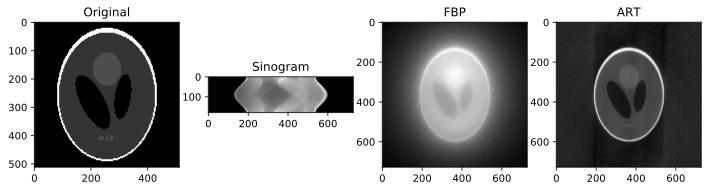

In [7]:
# Show results.
plt.figure(figsize=(12,4))
plt.subplot(141); plt.title('Original');
plt.imshow(obj.squeeze(), cmap='gray'); 
plt.subplot(142);  plt.title('Sinogram')
plt.imshow(sim.squeeze(), cmap='gray');
plt.subplot(143); plt.title('FBP');
plt.imshow(rec_fbp.squeeze(), cmap='gray');
plt.subplot(144); plt.title('ART');
plt.imshow(rec_art.squeeze(), cmap='gray');

<h3> <center> Astra Toolbox. Reconstruction Pipeline </center></h3>

The **[ASTRA Toolbox](https://www.astra-toolbox.com/)** is a MATLAB and Python toolbox of high-performance GPU primitives for 2D and 3D tomography.

<img src='astra.png'>

* W. van Aarle, W J. Palenstijn, J. De Beenhouwer, T. Altantzis, S. Bals, K. J. Batenburg, and J. Sijbers, *“The ASTRA Toolbox: a platform for advanced algorithm development in electron tomography”*, Ultramicroscopy, Vol. 147, p. 35–47, (2015)

* W J. Palenstijn, K J. Batenburg, and J. Sijbers, *“Performance improvements for iterative electron tomography reconstruction using graphics processing units (GPUs)”*, Journal of structural biology, vol. 176, issue 2, pp. 250-253, 2011


In [8]:
n_size = 256
obj = tomopy.misc.phantom.shepp2d(n_size).squeeze()

# Create a basic 128x128 square volume geometry
vol_geom = astra.create_vol_geom(n_size, n_size)

# Create a parallel beam geometry with 180 angles between 0 and pi, and 384 detector pixels of width 1.
proj_geom = astra.create_proj_geom('parallel', 1, 384, np.linspace(0,np.pi,180,False))


# Create a sinogram using the GPU or CPU.
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(obj, proj_id)

In [9]:
#### GPU RECONSTRUCTION ####

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the GPU
# Available algorithms:
# SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)
cfg = astra.astra_dict('SIRT_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 150 iterations of the algorithm
print('GPU, 150 iterations:')
% time astra.algorithm.run(alg_id, 150)

# Get the result
rec_sirt_cuda = astra.data2d.get(rec_id)

GPU, 150 iterations:
Wall time: 1.53 s


In [10]:
#### CPU RECONSTRUCTION ####

# Create a data object for the reconstruction
rec_cpu_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the extra ProjectorId setting.
# Available algorithms:
# ART, SART, SIRT, CGLS, FBP
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_cpu_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id


# Create the algorithm object from the configuration structure
alg_cpu_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm. This will have a runtime in the order of 10 seconds.
print('CPU, 150 iterations:')
% time  astra.algorithm.run(alg_cpu_id, 150)

# Get the result
rec_sirt = astra.data2d.get(rec_id)

CPU, 150 iterations:
Wall time: 78.1 ms


In [11]:
# Clean up. Note that GPU memory is tied up in the algorithm object, and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.algorithm.delete(alg_cpu_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(rec_cpu_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

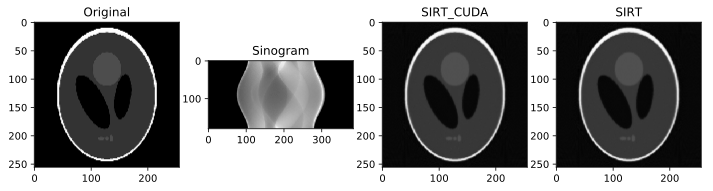

In [12]:
# Show results.
plt.figure(figsize=(12,4))
plt.subplot(141); plt.title('Original');
plt.imshow(obj, cmap='gray'); 
plt.subplot(142);  plt.title('Sinogram')
plt.imshow(sinogram, cmap='gray');
plt.subplot(143);  plt.title('SIRT_CUDA')
plt.imshow(rec_sirt_cuda, cmap='gray');
plt.subplot(144);  plt.title('SIRT')
plt.imshow(rec_sirt, cmap='gray');

<h3> <center> Astra Toolbox. 3D Geometry </center></h3>

In [13]:
n_size = 128
vol_geom = astra.create_vol_geom(n_size, n_size, n_size)

# create geometry
angles = np.linspace(0, np.pi, 180,False)
# create_proj_geom('parallel3d', detector_spacing_x, detector_spacing_y, det_row_count, det_col_count, angles)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 128, 192, angles)

# Create phantom
obj = tomopy.misc.phantom.shepp3d(n_size)

# Create projection data from this
proj_id, proj_data = astra.create_sino3d_gpu(obj, proj_geom, vol_geom)

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 150 iterations of the algorithm
# Note that this requires about 750MB of GPU memory, and has a runtime
# in the order of 10 seconds.
print('GPU, 150 iterations:')
% time  astra.algorithm.run(alg_id, 150)

# Get the result
rec = astra.data3d.get(rec_id)

# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

GPU, 150 iterations:
Wall time: 59.6 s


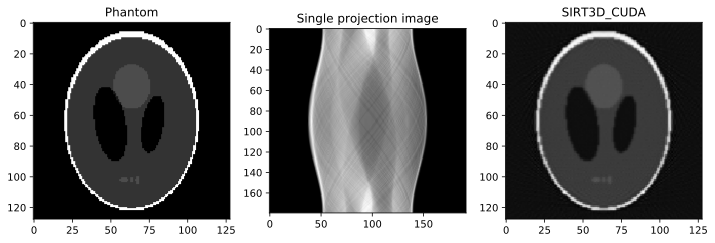

In [14]:
# Show results.
plt.figure(figsize=(12,4))
plt.subplot(131); plt.title('Phantom');
plt.imshow(obj[64,:,:], cmap='gray'); 
plt.subplot(132);  plt.title('Single projection image')
plt.imshow(proj_data[64,:,:], cmap='gray');
plt.subplot(133);  plt.title('SIRT3D_CUDA')
plt.imshow(rec[64,:,:], cmap='gray');


<h3> <center> TomoPy + Astra </center></h3>

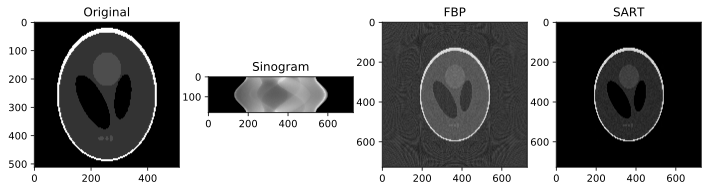

In [15]:
obj = tomopy.shepp2d() # Generate an object.
ang = tomopy.angles(180) # Generate uniformly spaced tilt angles.
sim = tomopy.project(obj, ang) # Calculate projections.

# Reconstruct object:
options = {'proj_type':'linear', 'method':'FBP'}
rec_fbp = tomopy.recon(sim, ang, algorithm=tomopy.astra, options=options)

options = options={'method':'SART', 'num_iter':10*180, 'proj_type':'linear', 'extra_options':{'MinConstraint':0}}
rec_sart = tomopy.recon(sim, ang, algorithm=tomopy.astra, options=options)


# Show results.
plt.figure(figsize=(12,4))
plt.subplot(141); plt.title('Original');
plt.imshow(obj.squeeze(), cmap='gray'); 
plt.subplot(142);  plt.title('Sinogram')
plt.imshow(sim.squeeze(), cmap='gray');
plt.subplot(143); plt.title('FBP');
plt.imshow(rec_fbp.squeeze(), cmap='gray');
plt.subplot(144); plt.title('SART');
plt.imshow(rec_sart.squeeze(), cmap='gray');

<h3><center> Reconstruction Methods </center></h3>
<img src='methods.png'>

* **Analytical**: BP, BPF, FBP

Reference: [Asl, Mahsa Noori, and Alireza Sadremomtaz. "Analytical image reconstruction methods in emission tomography." Journal of Biomedical Science and Engineering 6.01 (2013): 100.](http://file.scirp.org/Html/13-9101545_27659.htm)

* **Algebraic**

The algebraic reconstruction technique (ART) is a class of iterative algorithms used in computed tomography.
ART can be considered as an iterative solver of a system of linear equations $ A x = b $. The values of the pixels are considered as variables collected in a vector $x$, and the image process is described by a matrix $ A $. The measured angular projections are collected in a vector $b$. Given a real or complex  $m \times n $
matrix $A$ and a real or complex vector $b$
respectively, the method computes an approximation of the solution of the linear systems of equations as in the following formula,
$$  x^{k+1}   =   x^{k}   +   \lambda_k  \frac{b_{i} - \langle a_{i}, x^{k} \rangle}{\lVert a_{i} \rVert^2} a_{i}^{T}$$
where 
$i = k \, \bmod \, m + 1$, $a_i$  is the $i$-th row of the matrix $A$, $b_i$ is the $i$-th component of the vector $b$, 
and $\lambda_k$ is a relaxation parameter. The above formulae gives a simple iteration routine.
An advantage of ART over other reconstruction methods (such as FBP) is that it is relatively easy to incorporate prior knowledge into the reconstruction process. 

See, [*e.g.*](http://itas2012.iitp.ru/pdf/1569605161.pdf)

* **Statistical**